# Machine Learning Trading Bot

In this Challenge, you’ll assume the role of a financial advisor at one of the top five financial advisory firms in the world. Your firm constantly competes with the other major firms to manage and automatically trade assets in a highly dynamic environment. In recent years, your firm has heavily profited by using computer algorithms that can buy and sell faster than human traders.

The speed of these transactions gave your firm a competitive advantage early on. But, people still need to specifically program these systems, which limits their ability to adapt to new data. You’re thus planning to improve the existing algorithmic trading systems and maintain the firm’s competitive advantage in the market. To do so, you’ll enhance the existing trading signals with machine learning algorithms that can adapt to new data.

## Instructions:

Use the starter code file to complete the steps that the instructions outline. The steps for this Challenge are divided into the following sections:

* Establish a Baseline Performance

* Tune the Baseline Trading Algorithm

* Evaluate a New Machine Learning Classifier

* Create an Evaluation Report

#### Establish a Baseline Performance

In this section, you’ll run the provided starter code to establish a baseline performance for the trading algorithm. To do so, complete the following steps.

Open the Jupyter notebook. Restart the kernel, run the provided cells that correspond with the first three steps, and then proceed to step four. 

1. Import the OHLCV dataset into a Pandas DataFrame.

2. Generate trading signals using short- and long-window SMA values. 

3. Split the data into training and testing datasets.

4. Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

5. Review the classification report associated with the `SVC` model predictions. 

6. Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

7. Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

8. Write your conclusions about the performance of the baseline trading algorithm in the `README.md` file that’s associated with your GitHub repository. Support your findings by using the PNG image that you saved in the previous step.

#### Tune the Baseline Trading Algorithm

In this section, you’ll tune, or adjust, the model’s input features to find the parameters that result in the best trading outcomes. (You’ll choose the best by comparing the cumulative products of the strategy returns.) To do so, complete the following steps:

1. Tune the training algorithm by adjusting the size of the training dataset. To do so, slice your data into different periods. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. Answer the following question: What impact resulted from increasing or decreasing the training window?

> **Hint** To adjust the size of the training dataset, you can use a different `DateOffset` value&mdash;for example, six months. Be aware that changing the size of the training dataset also affects the size of the testing dataset.

2. Tune the trading algorithm by adjusting the SMA input features. Adjust one or both of the windows for the algorithm. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. Answer the following question: What impact resulted from increasing or decreasing either or both of the SMA windows?

3. Choose the set of parameters that best improved the trading algorithm returns. Save a PNG image of the cumulative product of the actual returns vs. the strategy returns, and document your conclusion in your `README.md` file.

#### Evaluate a New Machine Learning Classifier

In this section, you’ll use the original parameters that the starter code provided. But, you’ll apply them to the performance of a second machine learning model. To do so, complete the following steps:

1. Import a new classifier, such as `AdaBoost`, `DecisionTreeClassifier`, or `LogisticRegression`. (For the full list of classifiers, refer to the [Supervised learning page](https://scikit-learn.org/stable/supervised_learning.html) in the scikit-learn documentation.)

2. Using the original training data as the baseline model, fit another model with the new classifier.

3. Backtest the new model to evaluate its performance. Save a PNG image of the cumulative product of the actual returns vs. the strategy returns for this updated trading algorithm, and write your conclusions in your `README.md` file. Answer the following questions: Did this new model perform better or worse than the provided baseline model? Did this new model perform better or worse than your tuned trading algorithm?

#### Create an Evaluation Report

In the previous sections, you updated your `README.md` file with your conclusions. To accomplish this section, you need to add a summary evaluation report at the end of the `README.md` file. For this report, express your final conclusions and analysis. Support your findings by using the PNG images that you created.


In [1]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

---

## Establish a Baseline Performance

In this section, you’ll run the provided starter code to establish a baseline performance for the trading algorithm. To do so, complete the following steps.

Open the Jupyter notebook. Restart the kernel, run the provided cells that correspond with the first three steps, and then proceed to step four. 


### Step 1: mport the OHLCV dataset into a Pandas DataFrame.

In [2]:
# Import the OHLCV dataset into a Pandas Dataframe
ohlcv_df = pd.read_csv(
    Path("./Resources/emerging_markets_ohlcv.csv"), 
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
ohlcv_df.head()

,open,high,low,close,volume
date,,,,,
2015-01-21 09:30:00,23.83,23.83,23.83,23.83,100
2015-01-21 11:00:00,23.98,23.98,23.98,23.98,100
2015-01-22 15:00:00,24.42,24.42,24.42,24.42,100
2015-01-22 15:15:00,24.42,24.44,24.42,24.44,200
2015-01-22 15:30:00,24.46,24.46,24.46,24.46,200


In [3]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:, ["close"]]

# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns
date,,
2015-01-21 11:00:00,23.98,0.006295
2015-01-22 15:00:00,24.42,0.018349
2015-01-22 15:15:00,24.44,0.000819
2015-01-22 15:30:00,24.46,0.000818
2015-01-26 12:30:00,24.33,-0.005315


,close,Actual Returns
date,,
2021-01-22 09:30:00,33.27,-0.006866
2021-01-22 11:30:00,33.35,0.002405
2021-01-22 13:45:00,33.42,0.002099
2021-01-22 14:30:00,33.47,0.001496
2021-01-22 15:45:00,33.44,-0.000896


## Step 2: Generate trading signals using short- and long-window SMA values. 

In [4]:
# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463


,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495


In [5]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214,1.0
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308,1.0
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360,1.0
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411,1.0
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463,1.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0


In [6]:
# count and compare how many values there are in the feature "Signal"
signals_df['Signal'].value_counts()

 1.0    2368
-1.0    1855
Name: Signal, dtype: int64

In [7]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214,1.0,NaN
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308,1.0,0.000000
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360,1.0,0.000803
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411,1.0,0.000401
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463,1.0,0.001202


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0,0.002099
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0,0.001496
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0,-0.000896


<Axes: xlabel='date'>

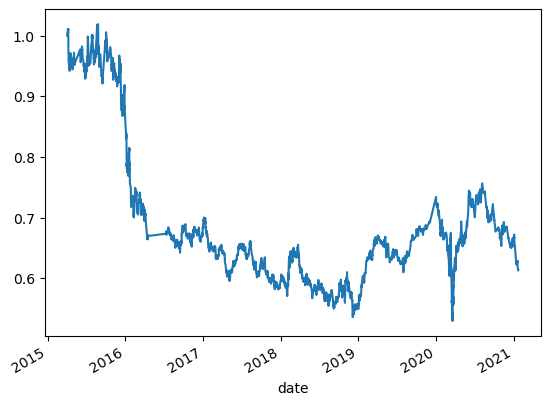

In [8]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

<Axes: xlabel='date'>

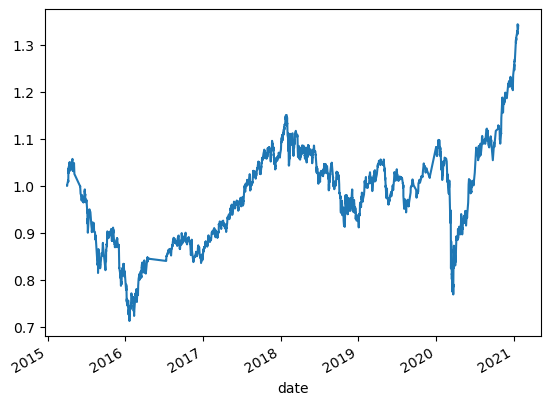

In [9]:
(1 + signals_df['Actual Returns']).cumprod().plot()


### Step 3: Split the data into training and testing datasets.

In [10]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


In [11]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

 1.0    2368
-1.0    1855
Name: Signal, dtype: int64

In [12]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-04-02 15:00:00


In [13]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2015-07-02 15:00:00


In [14]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
display(X_train.head())
display(X_train.tail())
display(len(X_train))

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


,SMA_Fast,SMA_Slow
date,,
2015-06-30 12:15:00,24.2150,25.2106
2015-06-30 14:00:00,24.1050,25.1930
2015-06-30 14:15:00,24.0775,25.1767
2015-06-30 15:00:00,24.1000,25.1597
2015-07-02 10:45:00,24.1175,25.1427


128

In [15]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
display(X_test.head())
display(X_test.tail())
display(len(X_test))

,SMA_Fast,SMA_Slow
date,,
2015-07-06 10:00:00,24.1250,25.0919
2015-07-06 10:45:00,23.9700,25.0682
2015-07-06 14:15:00,23.8475,25.0458
2015-07-06 14:30:00,23.6725,25.0206
2015-07-07 11:30:00,23.4800,24.9951


,SMA_Fast,SMA_Slow
date,,
2021-01-22 09:30:00,33.1725,30.36035
2021-01-22 11:30:00,33.2025,30.40215
2021-01-22 13:45:00,33.2725,30.44445
2021-01-22 14:30:00,33.3850,30.48745
2021-01-22 15:45:00,33.3775,30.53085


4092

In [16]:
# Review the y_test DataFrame
display(y_test.head())
display(y_test.tail())

display(len(y_test))

date
2015-07-06 10:00:00   -1.0
2015-07-06 10:45:00    1.0
2015-07-06 14:15:00   -1.0
2015-07-06 14:30:00   -1.0
2015-07-07 11:30:00   -1.0
Name: Signal, dtype: float64

date
2021-01-22 09:30:00   -1.0
2021-01-22 11:30:00    1.0
2021-01-22 13:45:00    1.0
2021-01-22 14:30:00    1.0
2021-01-22 15:45:00   -1.0
Name: Signal, dtype: float64

4092

In [17]:
# Create a StandardScaler instance
# Scale the features DataFrames
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Step 4: Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

In [18]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_train_scaled)

# Review the model's predicted values
svm_pred[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [19]:
display(len(svm_pred)) 

128

### Step 5: Review the classification report associated with the `SVC` model predictions. 

In [20]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_train, svm_pred)

# Print the classification report
print(svm_testing_report)


              precision    recall  f1-score   support

        -1.0       1.00      0.06      0.12        49
         1.0       0.63      1.00      0.77        79

    accuracy                           0.64       128
   macro avg       0.82      0.53      0.44       128
weighted avg       0.77      0.64      0.52       128



### Step 6: Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [21]:
# Create prediction with test data:
test_prediction_model = svm_model.predict(X_test_scaled)

In [22]:
display(test_prediction_model)
display(len(test_prediction_model))

array([1., 1., 1., ..., 1., 1., 1.])

4092

In [23]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = test_prediction_model

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = (
    predictions_df["Actual Returns"] * predictions_df["Predicted"]
)

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-07-06 10:00:00,1.0,-0.025715,-0.025715
2015-07-06 10:45:00,1.0,0.007237,0.007237
2015-07-06 14:15:00,1.0,-0.009721,-0.009721
2015-07-06 14:30:00,1.0,-0.003841,-0.003841
2015-07-07 11:30:00,1.0,-0.018423,-0.018423


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 09:30:00,1.0,-0.006866,-0.006866
2021-01-22 11:30:00,1.0,0.002405,0.002405
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


### Step 7: Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

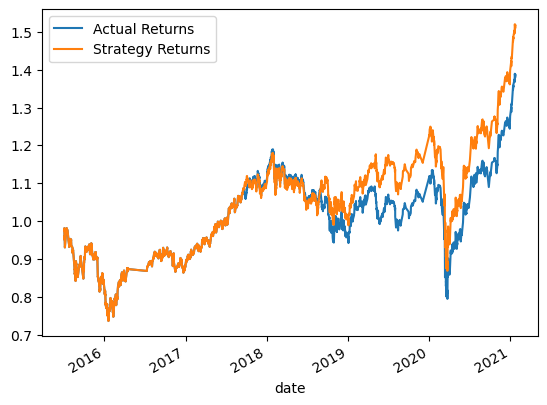

In [24]:
# Plot the actual returns versus the strategy returns
svm_plot_output = (1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()


<Axes: xlabel='date'>

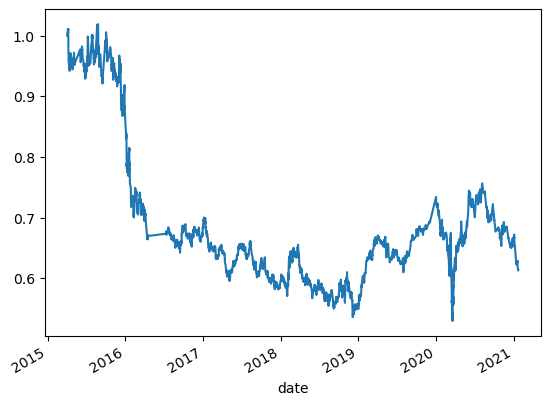

In [25]:
# Plot initial Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

---

## Tune the Baseline Trading Algorithm

## Step 6: Use an Alternative ML Model and Evaluate Strategy Returns

In this section, you’ll tune, or adjust, the model’s input features to find the parameters that result in the best trading outcomes. You’ll choose the best by comparing the cumulative products of the strategy returns.

In [73]:
# Create a new signals dataframe with different indicators and studies
signals_df = ohlcv_df.loc[:, [ "high", "low", "close"]]

# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,high,low,close,Actual Returns
date,,,,
2015-01-21 11:00:00,23.98,23.98,23.98,0.006295
2015-01-22 15:00:00,24.42,24.42,24.42,0.018349
2015-01-22 15:15:00,24.44,24.42,24.44,0.000819
2015-01-22 15:30:00,24.46,24.46,24.46,0.000818
2015-01-26 12:30:00,24.34,24.33,24.33,-0.005315


,high,low,close,Actual Returns
date,,,,
2021-01-22 09:30:00,33.27,33.27,33.27,-0.006866
2021-01-22 11:30:00,33.35,33.35,33.35,0.002405
2021-01-22 13:45:00,33.42,33.42,33.42,0.002099
2021-01-22 14:30:00,33.47,33.47,33.47,0.001496
2021-01-22 15:45:00,33.47,33.44,33.44,-0.000896


In [74]:
import pandas_ta as ta

# add study to signals_df
signals_df['RSI'] = ta.rsi(signals_df['close'], length = 16)
# signals_df['CCI'] = ta.cci(signals_df['high'], signals_df['low'], signals_df['close'], length=16)
macd_df = ta.macd(signals_df['close'], length = 16)
signals_df = signals_df.join(macd_df)
signals_df.dropna(inplace=True)
signals_df

,high,low,close,Actual Returns,RSI,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
date,,,,,,,,
2015-02-11 15:00:00,24.02,24.02,24.02,0.001668,47.737643,-0.042264,0.011013,-0.053278
2015-02-11 15:15:00,24.02,24.02,24.02,0.000000,47.737643,-0.041785,0.009194,-0.050979
2015-02-12 14:30:00,24.36,24.36,24.36,0.014155,64.038093,-0.013811,0.029735,-0.043545
2015-02-13 13:00:00,24.54,24.54,24.54,0.007389,69.423523,0.022623,0.052935,-0.030312
2015-02-13 13:45:00,24.52,24.52,24.52,-0.000815,68.212841,0.049315,0.063701,-0.014386
...,...,...,...,...,...,...,...,...
2021-01-22 09:30:00,33.27,33.27,33.27,-0.006866,72.528281,0.614753,0.022859,0.591895
2021-01-22 11:30:00,33.35,33.35,33.35,0.002405,73.323488,0.608847,0.013562,0.595285
2021-01-22 13:45:00,33.42,33.42,33.42,0.002099,74.025237,0.602866,0.006064,0.596802


In [75]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())
display(len(signals_df))

,high,low,close,Actual Returns,RSI,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,Signal
date,,,,,,,,,
2015-02-11 15:00:00,24.02,24.02,24.02,0.001668,47.737643,-0.042264,0.011013,-0.053278,1.0
2015-02-11 15:15:00,24.02,24.02,24.02,0.000000,47.737643,-0.041785,0.009194,-0.050979,1.0
2015-02-12 14:30:00,24.36,24.36,24.36,0.014155,64.038093,-0.013811,0.029735,-0.043545,1.0
2015-02-13 13:00:00,24.54,24.54,24.54,0.007389,69.423523,0.022623,0.052935,-0.030312,1.0
2015-02-13 13:45:00,24.52,24.52,24.52,-0.000815,68.212841,0.049315,0.063701,-0.014386,-1.0


,high,low,close,Actual Returns,RSI,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,Signal
date,,,,,,,,,
2021-01-22 09:30:00,33.27,33.27,33.27,-0.006866,72.528281,0.614753,0.022859,0.591895,-1.0
2021-01-22 11:30:00,33.35,33.35,33.35,0.002405,73.323488,0.608847,0.013562,0.595285,1.0
2021-01-22 13:45:00,33.42,33.42,33.42,0.002099,74.025237,0.602866,0.006064,0.596802,1.0
2021-01-22 14:30:00,33.47,33.47,33.47,0.001496,74.535610,0.595298,-0.001203,0.596501,1.0
2021-01-22 15:45:00,33.47,33.44,33.44,-0.000896,73.609948,0.580191,-0.013048,0.593239,-1.0


4289

In [76]:
# prepare data to split between test and train set
X = signals_df[['RSI', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9']].copy()
X

,RSI,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
date,,,,
2015-02-11 15:00:00,47.737643,-0.042264,0.011013,-0.053278
2015-02-11 15:15:00,47.737643,-0.041785,0.009194,-0.050979
2015-02-12 14:30:00,64.038093,-0.013811,0.029735,-0.043545
2015-02-13 13:00:00,69.423523,0.022623,0.052935,-0.030312
2015-02-13 13:45:00,68.212841,0.049315,0.063701,-0.014386
...,...,...,...,...
2021-01-22 09:30:00,72.528281,0.614753,0.022859,0.591895
2021-01-22 11:30:00,73.323488,0.608847,0.013562,0.595285
2021-01-22 13:45:00,74.025237,0.602866,0.006064,0.596802


In [77]:
# assign the signal feature to the y data set:
y = signals_df['Signal']
display(y)
# Review the value counts
display(y.value_counts())

date
2015-02-11 15:00:00    1.0
2015-02-11 15:15:00    1.0
2015-02-12 14:30:00    1.0
2015-02-13 13:00:00    1.0
2015-02-13 13:45:00   -1.0
                      ... 
2021-01-22 09:30:00   -1.0
2021-01-22 11:30:00    1.0
2021-01-22 13:45:00    1.0
2021-01-22 14:30:00    1.0
2021-01-22 15:45:00   -1.0
Name: Signal, Length: 4289, dtype: float64

 1.0    2415
-1.0    1874
Name: Signal, dtype: int64

In [78]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-02-11 15:00:00


### Step 1: Tune the training algorithm by adjusting the size of the training dataset. 

To do so, slice your data into different periods. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. 

Answer the following question: What impact resulted from increasing or decreasing the training window?

In [79]:
# split the dataset into the train and test datasets
training_begin = X.index.min()

# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=6)

# Display the training begin date
display(training_begin)

# Display the training end date
display(training_end)


Timestamp('2015-02-11 15:00:00')

Timestamp('2015-08-11 15:00:00')

In [80]:
# Generate the X_train and y_train DataFrames
X_train_nn = X.loc[training_begin:training_end]
y_train_nn = y.loc[training_begin:training_end]

# Review the X_train DataFrame
display(X_train_nn.head())
display(X_train_nn.tail())
display(len(X_train_nn))

,RSI,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
date,,,,
2015-02-11 15:00:00,47.737643,-0.042264,0.011013,-0.053278
2015-02-11 15:15:00,47.737643,-0.041785,0.009194,-0.050979
2015-02-12 14:30:00,64.038093,-0.013811,0.029735,-0.043545
2015-02-13 13:00:00,69.423523,0.022623,0.052935,-0.030312
2015-02-13 13:45:00,68.212841,0.049315,0.063701,-0.014386


,RSI,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
date,,,,
2015-08-06 10:00:00,42.282036,-0.044598,0.024985,-0.069583
2015-08-06 12:15:00,40.662931,-0.058400,0.008946,-0.067346
2015-08-07 11:30:00,38.071180,-0.076525,-0.007343,-0.069182
2015-08-07 15:30:00,38.901950,-0.088258,-0.015260,-0.072997
2015-08-11 12:00:00,37.300716,-0.101231,-0.022587,-0.078644


257

In [81]:
# Generate the X_test and y_test DataFrames
X_test_nn = X.loc[training_end+DateOffset(hours=1):]
y_test_nn = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
display(X_test_nn.head())
display(X_test_nn.tail())
display(len(X_test_nn))

,RSI,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
date,,,,
2015-08-12 09:30:00,30.403856,-0.134970,-0.045061,-0.089909
2015-08-12 09:45:00,29.466510,-0.163855,-0.059157,-0.104698
2015-08-12 10:00:00,29.927380,-0.183821,-0.063298,-0.120523
2015-08-12 10:15:00,29.927380,-0.197368,-0.061476,-0.135892
2015-08-12 10:30:00,30.953998,-0.204138,-0.054597,-0.149541


,RSI,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
date,,,,
2021-01-22 09:30:00,72.528281,0.614753,0.022859,0.591895
2021-01-22 11:30:00,73.323488,0.608847,0.013562,0.595285
2021-01-22 13:45:00,74.025237,0.602866,0.006064,0.596802
2021-01-22 14:30:00,74.535610,0.595298,-0.001203,0.596501
2021-01-22 15:45:00,73.609948,0.580191,-0.013048,0.593239


4032

## Step 2: Scale the features DataFrames

In [82]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train_nn)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_lr_scaled_nn = X_scaler.transform(X_train_nn)
X_test_lr_scaled_nn = X_scaler.transform(X_test_nn)

### Step 3: Tune the trading algorithm by adjusting the SMA input features. 

Adjust one or both of the windows for the algorithm. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. 

Answer the following question: What impact resulted from increasing or decreasing either or both of the SMA windows?

### Step 4: Choose the set of parameters that best improved the trading algorithm returns. 

Save a PNG image of the cumulative product of the actual returns vs. the strategy returns, and document your conclusion in your `README.md` file.

---

## Evaluate a New Machine Learning Classifier

In this section, you’ll use the original parameters that the starter code provided. But, you’ll apply them to the performance of a second machine learning model. 

### Step 1:  Import a new classifier, such as `AdaBoost`, `DecisionTreeClassifier`, or `LogisticRegression`. (For the full list of classifiers, refer to the [Supervised learning page](https://scikit-learn.org/stable/supervised_learning.html) in the scikit-learn documentation.)

In [96]:
# Import a new classifier from SKLearn
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, log_loss

NN = MLPClassifier(hidden_layer_sizes = (4, 4, 2, 1), random_state=10, verbose=0, max_iter=500, activation='relu')
NN.fit(X_train_nn, y_train_nn)
pred_train_nn = NN.predict(X_train_nn)
pred_test_nn = NN.predict(X_test_nn) 

acc_train_nn = accuracy_score(y_train_nn, pred_train_nn)
acc_test_nn = accuracy_score(y_test_nn, pred_test_nn)


In [97]:
# Review the accuracy of the model predictions:
print("** Train Results **")
print(f"Accuracy: {acc_train_nn:.4%}")
print("** Test Results **")
print(f"Accuracy: {acc_test_nn:.4%}")

** Train Results **
Accuracy: 59.5331%
** Test Results **
Accuracy: 56.3244%


### Step 2: Using the original training data as the baseline model, fit another model with the new classifier.

### Step 3: Backtest the new model to evaluate its performance. 

Save a PNG image of the cumulative product of the actual returns vs. the strategy returns for this updated trading algorithm, and write your conclusions in your `README.md` file. 

Answer the following questions: 
Did this new model perform better or worse than the provided baseline model? 
Did this new model perform better or worse than your tuned trading algorithm?

In [39]:
# Use a classification report to evaluate the model using the predictions and testing data
lr_training_report = classification_report(y_train_lr, lr_prediction)

# Review the classification report
print(lr_training_report)


              precision    recall  f1-score   support

        -1.0       0.68      0.44      0.53       104
         1.0       0.69      0.86      0.77       153

    accuracy                           0.69       257
   macro avg       0.68      0.65      0.65       257
weighted avg       0.69      0.69      0.67       257



### Step 2-A: Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [53]:
X_test_lr_scaled

array([[-1.28865   , -1.96912963, -0.55367122, -0.82251581, -0.32381024],
       [-1.34778207, -1.64522622, -0.71461097, -1.08183158, -0.41142072],
       [-1.31870829, -1.30706408, -0.82585446, -1.15801415, -0.50516403],
       ...,
       [ 1.46318643,  0.84360947,  3.55739744,  0.11804115,  3.74423147],
       [ 1.49538306,  0.79830862,  3.51522961, -0.01565622,  3.74244988],
       [ 1.43698811,  0.64474619,  3.4310588 , -0.23356278,  3.72312645]])

In [55]:
y_test_lr

date
2015-08-12 09:30:00   -1.0
2015-08-12 09:45:00   -1.0
2015-08-12 10:00:00    1.0
2015-08-12 10:15:00    1.0
2015-08-12 10:30:00    1.0
                      ... 
2021-01-22 09:30:00   -1.0
2021-01-22 11:30:00    1.0
2021-01-22 13:45:00    1.0
2021-01-22 14:30:00    1.0
2021-01-22 15:45:00   -1.0
Name: Signal, Length: 4032, dtype: float64

In [54]:
# Create prediction with test data:
lr_predicted_output = lr_model.predict(X_test_lr_scaled)

# Review the model's predicted values with test data
print(lr_predicted_output)

[-1. -1. -1. ... -1. -1. -1.]


In [98]:
# Create a new empty predictions DataFrame.
lr_predicted_df = pd.DataFrame(index=X_test_lr.index)

# Add the model predictions to the DataFrame
lr_predicted_df['Predicted Output'] = pred_test_nn

# Add the actual returns to the DataFrame
# Add the actual returns to the DataFrame
lr_predicted_df['Actual Returns'] = signals_df["Actual Returns"]

# Add the strategy returns to the DataFrame
lr_predicted_df['Strategy Output Returns'] = (
    lr_predicted_df["Actual Returns"] * lr_predicted_df["Predicted Output"]
)

# Review the DataFrame
display(lr_predicted_df.head())
display(lr_predicted_df.tail())


,Predicted Output,Actual Returns,Strategy Output Returns
date,,,
2015-08-12 09:30:00,1.0,-0.013815,-0.013815
2015-08-12 09:45:00,1.0,-0.002259,-0.002259
2015-08-12 10:00:00,1.0,0.000453,0.000453
2015-08-12 10:15:00,1.0,0.000000,0.000000
2015-08-12 10:30:00,1.0,0.000905,0.000905


,Predicted Output,Actual Returns,Strategy Output Returns
date,,,
2021-01-22 09:30:00,1.0,-0.006866,-0.006866
2021-01-22 11:30:00,1.0,0.002405,0.002405
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


<Axes: xlabel='date'>

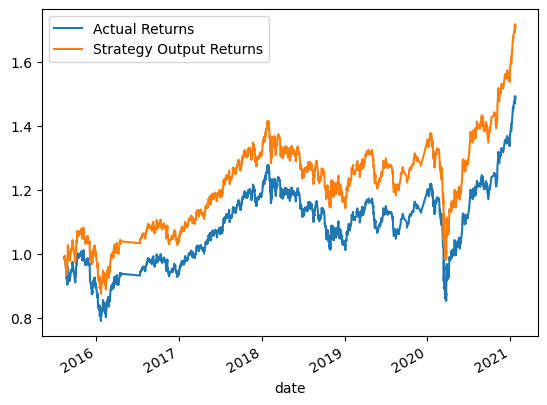

In [99]:
# Plot the actual returns versus the strategy returns
(1 + lr_predicted_df[["Actual Returns", "Strategy Output Returns"]]).cumprod().plot()

<Axes: xlabel='date'>

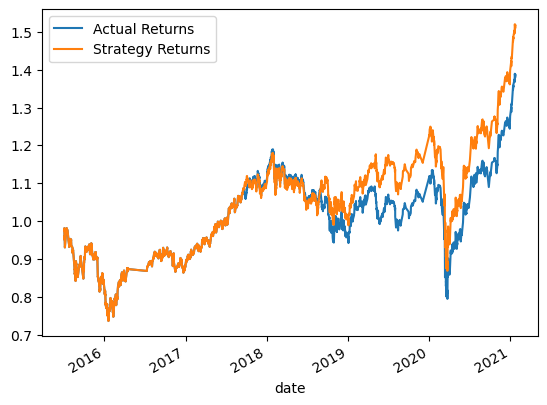

In [100]:
# Plot the actual returns versus the strategy returns for the SVM
(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()

# Create an Evaluation Report

We tried a neural network model as a second alternative to predict the price of the stock and we could not find the same level of accuracy in the prediction. The SVM model worked much better.
We even provided more indicator to analyze the trend and this did not help the learning model achive better performance.
